# CIFAR10을 CNN으로 학습하기. 여러 학습 방법으로 비교

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt

#learning rate decay
from torch.optim import lr_scheduler

batch_size=16
learning_rate=0.002
num_epoch=5

## 1. CIFAR10 train, test dataset 가져오기

In [5]:
cifar_train=dset.CIFAR10("CIFAR10/",train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
cifar_test=dset.CIFAR10("CIFAR10/",train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

#(2) Data augmentation
#train할 때만 필요(많이 가지게끔..), test할때는 필요가 없다.
#cifar_train=dset.CIFAR10("CIFAR10/",train=True, transform=transforms.Compose([transforms.Scale(36),transforms.CenterCrop(32),transforms.RandomHorizontalFlip(),transforms.Lambda(lambda x: x.rotate(90)),transforms.ToTensor()]))

#(4) Data Normalization
'''
cifar_train=dset.CIFAR10("CIFAR10/",train=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5)),
                        ])
                         ,target_transform=None,download=False)
cifar_test=dset.CIFAR10("CIFAR10/",train=False,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            #train이랑 같은 값 넣어야함
                            transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5)),
                        ])
                         ,target_transform=None,download=False)
'''


Files already downloaded and verified
Files already downloaded and verified


'\ncifar_train=dset.CIFAR10("CIFAR10/",train=True,\n                        transform=transforms.Compose([\n                            transforms.ToTensor(),\n                            transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5)),\n                        ])\n                         ,target_transform=None,download=False)\ncifar_test=dset.CIFAR10("CIFAR10/",train=False,\n                        transform=transforms.Compose([\n                            transforms.ToTensor(),\n                            #train\xec\x9d\xb4\xeb\x9e\x91 \xea\xb0\x99\xec\x9d\x80 \xea\xb0\x92 \xeb\x84\xa3\xec\x96\xb4\xec\x95\xbc\xed\x95\xa8\n                            transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5)),\n                        ])\n                         ,target_transform=None,download=False)\n'

## 2. 대략적인 데이터 형태

cifar_train 길이: 50000
cifar_test 길이: 10000
image data 형태:  torch.Size([3, 32, 32])
label:  2


<function matplotlib.pyplot.show>

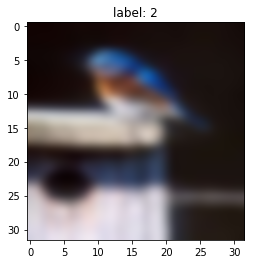

In [6]:
print "cifar_train 길이:",len(cifar_train)
print "cifar_test 길이:",len(cifar_test)

#데이터 하나 형태
image, label=cifar_train.__getitem__(13) #1번째 데이터
print "image data 형태: ",image.size()
print "label: ",label

#그리기
img=image.numpy() #image 타입을 numpy로 변환(3, 32, 32)

#(3,32,32)->(32,32,3)
r,g,b=img[0,:,:],img[1,:,:],img[2,:,:]

#img=img.reshape(img.shape[1],img.shape[2],img.shape[0])
img2=np.zeros((img.shape[1],img.shape[2],img.shape[0]))
img2[:,:,0],img2[:,:,1],img2[:,:,2]=r,g,b

plt.title("label: %d" %label)
plt.imshow(img2,interpolation='bicubic')
plt.show

In [7]:
def ComputeAccr(dloader, imodel):
    correct=0
    total=0
    
    for j, [imgs,labels] in enumerate(dloader): #batch_size 만큼
        img=Variable(imgs,volatile=True)#.cuda() #x
        #label=Variable(labels) #y
        label=Variable(labels) #.cuda()
        #.cuda(): GPU에 로드되기 위함, 만약 CPU로 설정되어 있다면 에러남
        
        output=imodel.forward(img)#forward prop.
        _, output_index=torch.max(output,1)
        
        total+=label.size(0)
        correct+=(output_index==label).sum().float()
    print("Accuracy of Test Data: {}".format(100*correct/total))

In [8]:
def ComputeAccr2(dloader, imodel):
    correct=0
    total=0
    
    for j, [imgs,labels] in enumerate(dloader): #batch_size 만큼
        img=Variable(imgs,volatile=True)#.cuda() #x
        #label=Variable(labels) #y
        label=Variable(labels) #.cuda()
        #.cuda(): GPU에 로드되기 위함, 만약 CPU로 설정되어 있다면 에러남
        
        output=imodel.forward(img)#forward prop.
        _, output_index=torch.max(output,1)
        
        total+=label.size(0)
        correct+=(output_index==label).sum().float()
    return format(100*correct/total)

In [9]:
# ==3.데이터 로드함수
train_loader=torch.utils.data.DataLoader(list(cifar_train)[:],batch_size=batch_size,shuffle=True,num_workers=2,drop_last=True)
test_loader=torch.utils.data.DataLoader(cifar_test,batch_size=batch_size,shuffle=False,num_workers=2,drop_last=True)

# ==4.모델 선언
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer=nn.Sequential(
            nn.Conv2d(3,16,3,padding=1),
            nn.ReLU(),
            #nn.Dropout2d(0.2), #(1)drop out -->0.2: 몇퍼센트의 확률로 끌 것인가?(설정 안하면 0.5가됨)
            ##nn.BatchNorm2d(16), #(5) Batch normalization
            nn.Conv2d(16,32,3,padding=1),
            nn.ReLU(),
            #nn.Dropout2d(0.2), #(1)drop out
            ##nn.BatchNorm2d(32), #(5) Batch normalization
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,3,padding=1),
            nn.ReLU(),
            #nn.Dropout2d(0.2), #(1)drop out
            ##nn.BatchNorm2d(64), #(5) Batch normalization
            nn.MaxPool2d(2,2)
        )
        self.fc_layer=nn.Sequential(
            nn.Linear(64*8*8,100),
            nn.ReLU(),
             #nn.Dropout2d(0.2), #(1)drop out
            ##nn.BatchNorm1d(100), #(5) Batch normalization, 얘만 fully connected 다음이라 1d임
            nn.Linear(100,10)
        )
    
        #(3)weight initialization
    '''py
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                init.kaiming_normal(m.weight.data)##RELU일 때
                m.bias.data.fill_(0)

            if isinstance(m,nn.Linear):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
     '''
    
    def forward(self,x):
        out=self.layer(x)
        out=out.view(batch_size,-1)
        out=self.fc_layer(out)
        
        return out
model=CNN()#.cuda()

(0, tensor(2.3171, grad_fn=<NllLossBackward>))
(1000, tensor(2.3032, grad_fn=<NllLossBackward>))
(2000, tensor(2.2977, grad_fn=<NllLossBackward>))
(3000, tensor(2.3058, grad_fn=<NllLossBackward>))


/home/ec2-user/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


(0, tensor(2.3001, grad_fn=<NllLossBackward>))
(1000, tensor(2.2830, grad_fn=<NllLossBackward>))
(2000, tensor(2.2652, grad_fn=<NllLossBackward>))
(3000, tensor(2.0523, grad_fn=<NllLossBackward>))
(0, tensor(2.1085, grad_fn=<NllLossBackward>))
(1000, tensor(2.1019, grad_fn=<NllLossBackward>))
(2000, tensor(2.2415, grad_fn=<NllLossBackward>))
(3000, tensor(2.1128, grad_fn=<NllLossBackward>))
(0, tensor(1.6898, grad_fn=<NllLossBackward>))
(1000, tensor(1.8200, grad_fn=<NllLossBackward>))
(2000, tensor(1.5614, grad_fn=<NllLossBackward>))
(3000, tensor(2.1634, grad_fn=<NllLossBackward>))
(0, tensor(1.6907, grad_fn=<NllLossBackward>))
(1000, tensor(1.9351, grad_fn=<NllLossBackward>))
(2000, tensor(1.6165, grad_fn=<NllLossBackward>))
(3000, tensor(1.5048, grad_fn=<NllLossBackward>))


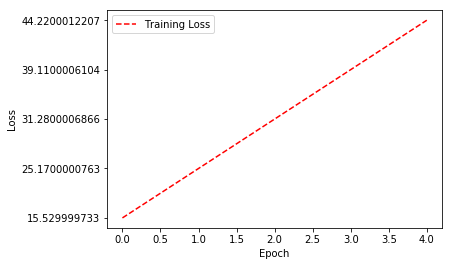

In [10]:
# ==5. loss, optimizer
loss_func=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)
#optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate) #(6)Adam optimizer

scheduler=lr_scheduler.StepLR(optimizer,step_size=20,gamma=0.2) #(7)learning rate decay
# ==6. 학습
accr=[]
epoch=[]
model.train()
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x=Variable(image)#.cuda
        y_=Variable(label)#.cuda()
        
        optimizer.zero_grad()
        output=model.forward(x)
        loss=loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
        if j%1000==0:
            print(j,loss)
    if i%1==0:
        accr.append(ComputeAccr2(test_loader,model))
        epoch.append(i)
training_loss = ComputeAccr2(test_loader,model)
model.eval()
 # 손실 값의 기록을 시각화합니다.
plt.plot(epoch,accr, "r--")
plt.legend(["Training Loss", "Test Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [1]:
plt.plot(epoch,accr)
plt.legend(["Training Loss", "Test Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

NameError: name 'plt' is not defined

## (7)learning rate decay

In [8]:
ComputeAccr(test_loader,model)

/home/ec2-user/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Accuracy of Test Data: 44.6500015259


## (0)Naive Test

In [14]:
ComputeAccr(test_loader,model)

/home/ec2-user/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Accuracy of Test Data: 15.2600002289


## (1)Drop out

In [18]:
ComputeAccr(test_loader,model)

/home/ec2-user/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Accuracy of Test Data: 15.9899997711


## (2) Data augmentation

In [24]:
ComputeAccr(test_loader,model)

/home/ec2-user/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Accuracy of Test Data: 25.9300003052


## (3) Weight initialization

In [32]:
ComputeAccr(test_loader,model)

/home/ec2-user/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Accuracy of Test Data: 43.5499992371


## (4)Data Normalization

In [11]:
ComputeAccr(test_loader,model)

/home/ec2-user/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Accuracy of Test Data: 30.9200000763


## (5) Batch normalization

In [20]:
ComputeAccr(test_loader,model)

/home/ec2-user/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Accuracy of Test Data: 59.5400009155


## (6) Adam optimizer

In [7]:
ComputeAccr(test_loader,model)

/home/ec2-user/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Accuracy of Test Data: 55.2200012207
